In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns
from lmfit.models import LinearModel, PowerLawModel

from scripts.stress_hyper import shear_stress_hyper_wc60_lc500_net_strain_ir_20240226

In [2]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.65, rc={'grid.linewidth': 0.5})

In [3]:
def get_stable_df(df, x_min, x_max, gr_by='sample'):
    idx = (x_min < df['x_hyper']) & (df['x_hyper'] < x_max)
    # feature to group by
    df_stable = df[idx]
    df_median = df_stable.groupby(by=[gr_by, 'flow_rate'], as_index=False).median()
    df_mean = df_stable.groupby(by=[gr_by, 'flow_rate'], as_index=False).mean()
    df_sem = df_stable.groupby(by=[gr_by, 'flow_rate'], as_index=False).sem()

    df_median['stress'] = df_median['net_strain_inert'] * df_median['emodulus']
    df_mean['stress'] = df_mean['net_strain_inert'] * df_mean['emodulus']
    df_sem['stress'] = df_sem['net_strain_inert'] * df_median['emodulus']

    return df_median, df_mean, df_sem

def plot_df(df, gr_by = 'sample',
            x_feat='flow_rate', y_feat='net_strain_inert',
            hue_order=None, style_order=None,
            log=False, xlim=None, ylim=None,
            xlabel="Flow rate [µL/s]", ylabel=r"Strain $\varepsilon$",
            title="$w_c=60\,$µm, $L_c=500\,$µm"):

    fig, ax = plt.subplots(1, 1, figsize=(7,5))

    sns.scatterplot(data=df,
                    x=x_feat, y=y_feat,
                    hue=gr_by, hue_order=hue_order, palette='crest',
                    style=gr_by,
                    s=200, edgecolor='w', linewidth=2,
                    ax=ax)
    if log:
        ax.set(xscale='log', yscale='log')
        ax.grid(which='minor')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='upper left')

    return fig, ax

def get_df_strain_features(df_in):
    df_in['strain_inert'] = df_in['inert_ratio_raw'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert'] = ((df_in['inert_ratio_raw'] - 1)
                                 / np.sqrt(df_in['inert_ratio_raw']))
    # ellipse features
    df_in['net_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                               / np.sqrt(df_in['ell_major'] * df_in['ell_minor']))
    df_in['taylor_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                                  / (df_in['ell_major'] + df_in['ell_minor']))
    return df_in

def fsize_cm(size_x, size_y):
    """
    
    :param size_x: Figure width in inch
    :param size_y: Figure height in inch
    :return: tuple(width, height) in cm
    """
    return size_x / 2.54, size_y / 2.54


### load data from file

In [4]:
save_path = os.path.join("..\\data",
                         "20230222_bead_stress_measurements",
                         "20230809_summary_beads_20230222.tsv")
df_wc60_lc500 = pd.read_csv(save_path, sep='\t', index_col=0)
df_wc60_lc500 = get_df_strain_features(df_wc60_lc500)
# values for x_hyper were incorrect in source file
df_wc60_lc500['x_hyper'] = df_wc60_lc500['x_hyper'] - 50

Filter the data

In [5]:
filter_idx = (df_wc60_lc500['area_ratio'] < 1.05) \
             & (df_wc60_lc500['aspect'] <= 2)
df_wc60_lc500 = df_wc60_lc500[filter_idx]

# only include flow rates < 0.16 ul/s
df_wc60_lc500 = df_wc60_lc500[df_wc60_lc500['flow_rate'] < 0.16]

Add shear stress

In [6]:
# calculation based on deformation of sphere into ellipsoid in planar elongation
diameter = (df_wc60_lc500['size_x'] + df_wc60_lc500['size_y']) / 2
df_wc60_lc500['shear_stress'] \
    = shear_stress_hyper_wc60_lc500_net_strain_ir_20240226(
    df_wc60_lc500['x_hyper'], diameter, df_wc60_lc500['flow_rate'])

## Plot strain over x

Create evenly sized bins over x and group data by x-bin, sample, flow rate and object number

In [7]:
x_min = 250
x_max = 325
idx = (x_min < df_wc60_lc500['x_hyper']) & (df_wc60_lc500['x_hyper'] < x_max)
df_plot_xdata = df_wc60_lc500.loc[idx]
bins = pd.cut(df_plot_xdata['x_hyper'], 20)
df_median_x_bins = df_plot_xdata.groupby(by=['sample', 'flow_rate', bins], as_index=False, observed=False).median()
df_sd_x_bins = df_plot_xdata.groupby(by=['sample', 'flow_rate', bins], as_index=False, observed=False).std()
df_sem_x_bins = df_plot_xdata.groupby(by=['sample', 'flow_rate', bins], as_index=False, observed=False).sem()
df_p25_x_bins = df_plot_xdata.groupby(by=['sample', 'flow_rate', bins], as_index=False, observed=False).quantile(0.25)
df_p75_x_bins = df_plot_xdata.groupby(by=['sample', 'flow_rate', bins], as_index=False, observed=False).quantile(0.75)

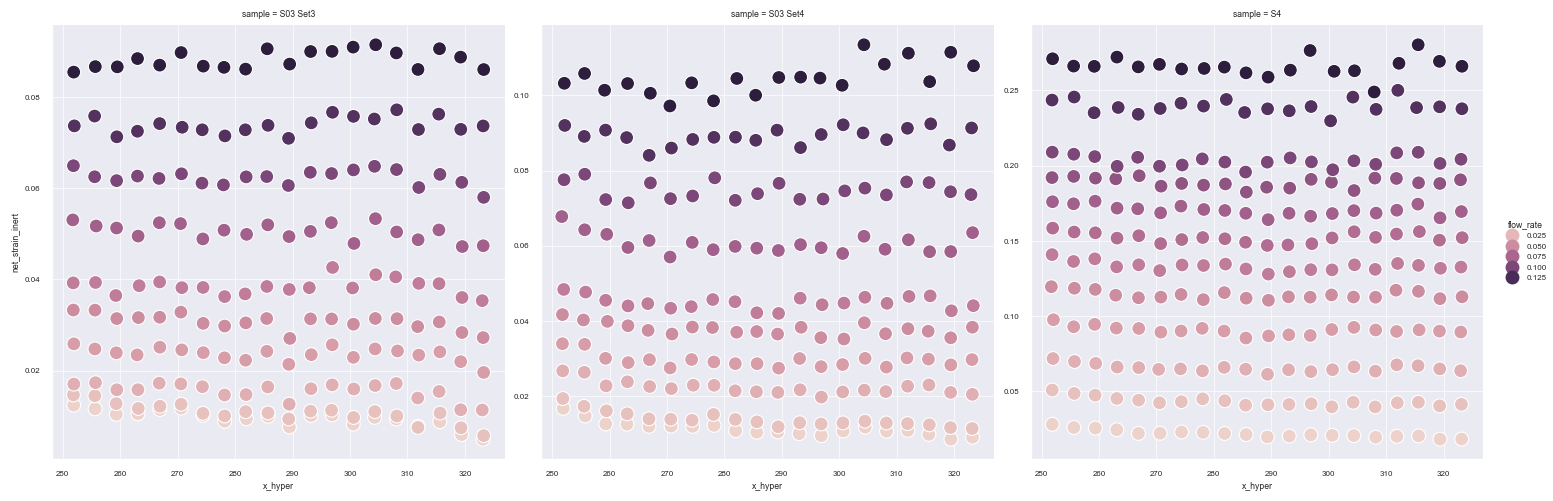

In [8]:
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.relplot(data=df_median_x_bins, x='x_hyper', y='net_strain_inert',
            hue='flow_rate', palette='ch:',
            col='sample', 
            kind='scatter', s=100,
            facet_kws={'sharey': False}
            )
plt.show()

Plot only S4 for the paper

In [9]:
df_s4_med_x_bins = df_median_x_bins.loc[df_median_x_bins['sample'] == 'S4']
df_s4_sd_x_bins = df_sd_x_bins.loc[df_median_x_bins['sample'] == 'S4']
df_s4_sem_x_bins = df_sem_x_bins.loc[df_median_x_bins['sample'] == 'S4']
df_s4_p25_x_bins = df_p25_x_bins.loc[df_median_x_bins['sample'] == 'S4']
df_s4_p75_x_bins = df_p75_x_bins.loc[df_median_x_bins['sample'] == 'S4']

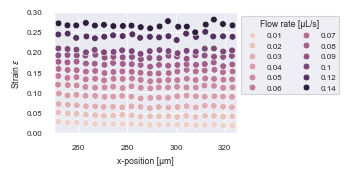

In [10]:
fsize = fsize_cm(6,4)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.scatterplot(data=df_s4_med_x_bins, x='x_hyper', y='net_strain_inert', 
                hue='flow_rate', palette='ch:',
                # s=120,
                ax=ax, legend='full')

ax.set_xlim(250, 325)
ax.set_ylim(0, 0.3)

ax.set_xlabel("x-position [µm]")
ax.set_ylabel(r"Strain $\varepsilon$")

ax.legend(title="Flow rate [µL/s]", #title_fontsize=11,
          ncol=2, #fontsize=10,
          loc='upper left', bbox_to_anchor=[1,1])
# ax.legend(title="Flow rate [µL/s]", title_fontsize=11,
#           ncol=5, fontsize=10,
#           loc=[0.01, 1.05])

plt.show()

#### Plot velocity over x to get extension rate 

Use full x-range because the velocity slope is not very apparent over the smaller range

In [11]:
df_s4_velocity_cut = df_wc60_lc500.loc[(df_wc60_lc500['sample'] == 'S4') 
                                       & (250 < df_wc60_lc500['x_hyper'])]
bins = pd.cut(df_s4_velocity_cut['x_hyper'], 30)
df_s4_med_velocity = df_s4_velocity_cut.groupby(by=['sample', 'flow_rate', bins], 
                                                as_index=False, observed=False).median()
df_s4_sd_velocity = df_s4_velocity_cut.groupby(by=['sample', 'flow_rate', bins],
                                                as_index=False, observed=False).std()
df_s4_sem_velocity = df_s4_velocity_cut.groupby(by=['sample', 'flow_rate', bins],
                                                as_index=False, observed=False).sem()

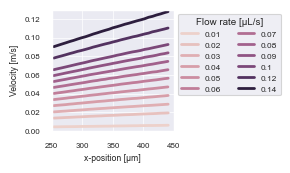

In [12]:
fsize = fsize_cm(4,4)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.lineplot(data=df_s4_med_velocity, x='x_hyper', y='-velocity',
                hue='flow_rate', palette='ch:',
                lw=2, ax=ax, legend='full')

ax.set_xlim(250, 450)
ax.set_ylim(0, 0.13)

ax.set_xlabel("x-position [µm]")
ax.set_ylabel(r"Velocity [m/s]")

ax.legend(title="Flow rate [µL/s]", title_fontsize=7,
          ncol=2, fontsize=6,
          loc='upper left', bbox_to_anchor=[1,1])
plt.show()

#### Combine both plots and create shared legend

In [13]:
df_s4_med_velocity['velocity [mm/s]'] = df_s4_med_velocity['-velocity'] *1e3

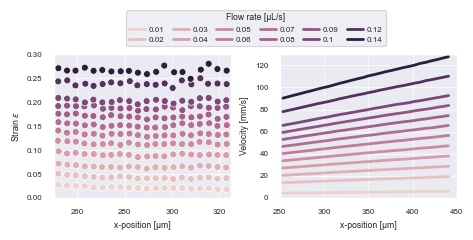

In [14]:
fsize = fsize_cm(12,5)
fig, axes = plt.subplots(1, 2, figsize=fsize)
ax1, ax2 = axes

# strain plot
sns.scatterplot(data=df_s4_med_x_bins, x='x_hyper', y='net_strain_inert',
                hue='flow_rate', palette='ch:',
                s=25, linewidth=0.5,
                ax=ax1, legend=False)

ax1.set_xlim(250, 325)
ax1.set_ylim(0, 0.3)

ax1.set_xlabel("x-position [µm]")
ax1.set_ylabel(r"Strain $\varepsilon$")

# velocity plot
sns.lineplot(data=df_s4_med_velocity, x='x_hyper', y='velocity [mm/s]',
             hue='flow_rate', palette='ch:',
             lw=2, ax=ax2, legend='full')

ax2.set_xlim(250, 450)
ax2.set_ylim(0, 130)

ax2.set_xlabel("x-position [µm]")
ax2.set_ylabel(r"Velocity [mm/s]")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend_ = None

# create figure legend
fig.legend(handles, labels, title="Flow rate [µL/s]",
           loc='lower center', bbox_to_anchor=[0.54, 0.96],
           ncol=6, columnspacing=1.0, handletextpad=0.5)
# fig.legend(handles, labels, title="Flow rate [µL/s]",
#            loc='upper left', bbox_to_anchor=[1, 1],
#            ncol=1, labelspacing=1.0, columnspacing=1.0, handletextpad=0.8)

plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\fig2_strain_velocity.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

Get number of beads per flow_rate

In [15]:
print("Number of unique beads per flow rate:")
flow_rates = df_s4_velocity_cut['flow_rate'].unique()
for fr in flow_rates:
    df_fr = df_s4_velocity_cut.loc[df_s4_velocity_cut['flow_rate'] == fr]
    print(f"{fr}: {len(df_fr['object_number'].unique())}")

Number of unique beads per flow rate:
0.01: 442
0.02: 700
0.03: 1002
0.04: 1382
0.05: 1752
0.06: 2222
0.07: 2094
0.08: 2302
0.09: 2295
0.1: 2422
0.12: 2069
0.14: 1831


Plot with error bars

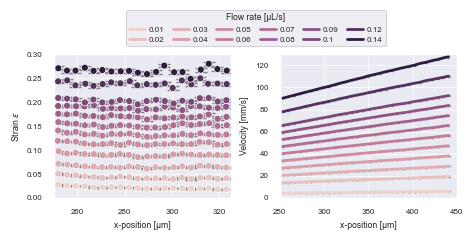

In [16]:
fsize = fsize_cm(12,5)
fig, axes = plt.subplots(1, 2, figsize=fsize)
ax1, ax2 = axes

# strain plot
sns.scatterplot(data=df_s4_med_x_bins, x='x_hyper', y='net_strain_inert',
                hue='flow_rate', palette='ch:',
                s=25, linewidth=0.5, zorder=10,
                ax=ax1, legend=False)
ax1.errorbar(df_s4_med_x_bins['x_hyper'], df_s4_med_x_bins['net_strain_inert'],
             yerr=df_s4_sem_x_bins['net_strain_inert'],
             lw=0, markersize=0, alpha=1, 
             elinewidth=1,  ecolor='gray', capsize=4,
             zorder=1)
# net_strain_iqr = [df_s4_p25_x_bins['net_strain_inert'].to_numpy(),
#                   df_s4_p75_x_bins['net_strain_inert'].to_numpy()]
# ax1.errorbar(df_s4_med_x_bins['x_hyper'], df_s4_med_x_bins['net_strain_inert'],
#              yerr=net_strain_iqr,
#              lw=0, markersize=0, alpha=0.6,
#              elinewidth=1, ecolor='gray', capsize=2,
#              zorder=1)

ax1.set_xlim(250, 325)
ax1.set_ylim(0, 0.3)

ax1.set_xlabel("x-position [µm]")
ax1.set_ylabel(r"Strain $\varepsilon$")

# velocity plot
sns.lineplot(data=df_s4_med_velocity, x='x_hyper', y='velocity [mm/s]',
             hue='flow_rate', palette='ch:',
             lw=2, ax=ax2, legend='full')
ax2.errorbar(df_s4_med_velocity['x_hyper'], df_s4_med_velocity['velocity [mm/s]'],
             yerr=df_s4_sem_velocity['-velocity']*1e3,
             lw=0, markersize=0, alpha=1,
             elinewidth=1, ecolor='gray', capsize=1, 
             zorder=1)

ax2.set_xlim(250, 450)
ax2.set_ylim(0, 130)

ax2.set_xlabel("x-position [µm]")
ax2.set_ylabel(r"Velocity [mm/s]")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend_ = None

# create figure legend
fig.legend(handles, labels, title="Flow rate [µL/s]",
           loc='lower center', bbox_to_anchor=[0.54, 0.96],
           ncol=6, columnspacing=1.0, handletextpad=0.5)
# fig.legend(handles, labels, title="Flow rate [µL/s]",
#            loc='upper left', bbox_to_anchor=[1, 1],
#            ncol=1, labelspacing=1.0, columnspacing=1.0, handletextpad=0.8)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_strain_velocity.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

## Plot strain and resulting shear stress influence before and after hyperbolic region
### Stress in inlet

In [17]:
df_before = pd.read_csv("..\\data\\20231121_beads_outside_hyper\\20231121_beads_before_hyper.tsv",
                        sep='\t', index_col=0)

C:\Users\freiche\AppData\Local\Temp\ipykernel_37280\2626189089.py:1: DtypeWarning: Columns (46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_before = pd.read_csv("..\\data\\20231121_beads_outside_hyper\\20231121_beads_before_hyper.tsv",


In [18]:
strain_feat = 'net_strain_inert'

In [19]:
df_before['emodulus'] = df_before['sample'].map({'s4_17um': 379,
                                                 's4_18um': 669,
                                                 's8_15um': 832,
                                                 's8_15um_20230731': 832,
                                                 's4_12um': 300,
                                                 })

In [20]:
df_analysis = df_before.loc[df_before['flow_rate'] > 0.01]

In [21]:
df_analysis['stress'] = df_analysis[strain_feat] * df_analysis['emodulus']
n_scaling = 2
df_analysis['stress_scaled'] = df_analysis['stress'] / (df_analysis['confinement'] ** n_scaling)

C:\Users\freiche\AppData\Local\Temp\ipykernel_37280\418508563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['stress'] = df_analysis[strain_feat] * df_analysis['emodulus']
C:\Users\freiche\AppData\Local\Temp\ipykernel_37280\418508563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['stress_scaled'] = df_analysis['stress'] / (df_analysis['confinement'] ** n_scaling)


In [22]:
df_median_before = df_analysis.groupby(by=['emodulus', 'flow_rate'],
                                       as_index=False).median(numeric_only=True)
df_sem_before = df_analysis.groupby(by=['emodulus', 'flow_rate'],
                                    as_index=False).sem(numeric_only=True)
df_median_before['emodulus'] = df_median_before['emodulus'].astype(int)
df_median_before['radius'] = df_median_before['radius'].round(decimals=1)

#### Fit strain data

##### Do fit for each sample and use the intercept to estimate the strain offset and correct for further analysis.

In [23]:
samples = df_median_before['emodulus'].unique()
df_fit_paras = pd.DataFrame()
for sample in samples:
    df = df_median_before[df_median_before['emodulus'] == sample].copy()
    x_data = df['flow_rate']
    y_data = df[strain_feat]

    model = LinearModel()
    # use built-in default values for paras from lmfit
    paras = model.guess(y_data, x=x_data)
    result = model.fit(y_data, paras, x=x_data, nan_policy='omit')

    slope = result.best_values['slope']
    slope_err = result.params['slope'].stderr
    ict = result.best_values['intercept']
    ict_err = result.params['intercept'].stderr

    df_temp = pd.DataFrame()
    df_temp['sample'] = [sample]
    df_temp['emodulus'] = df['emodulus'].unique()
    df_temp['radius'] = df['radius'].unique()
    df_temp['slope'] = [slope]
    df_temp['slope_err'] = [slope_err]
    df_temp['intercept'] = [ict]
    df_temp['intercept_err'] = [ict_err]
    df_fit_paras = pd.concat([df_fit_paras, df_temp], ignore_index=True)

In [24]:
df_fit_paras['intercept_err_rel'] = df_fit_paras['intercept_err'] / df_fit_paras['intercept']

In [25]:
df_fit_paras

sample  emodulus  radius     slope  slope_err  intercept  intercept_err  \
0     300       300     5.5  0.062348   0.002504   0.003446       0.000166   
1     379       379     7.3  0.069354   0.002353   0.004659       0.000156   
2     669       669     8.3  0.063505   0.007793   0.003280       0.000517   
3     832       832     6.6  0.045228   0.001763   0.003486       0.000117   

   intercept_err_rel  
0           0.048194  
1           0.033501  
2           0.157586  
3           0.033549

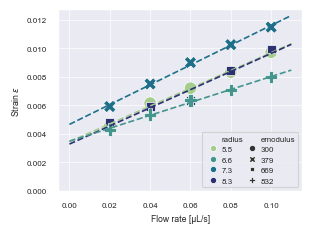

In [26]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_before,
                x='flow_rate', y=strain_feat,
                hue='radius', palette='crest',
                style='emodulus',
                linewidth=0.5,
                s=80, ax=ax, legend='full'
                )

x_plot = np.linspace(0, 0.11, 100)
rads = df_median_before['radius'].unique()
colors = sns.color_palette('crest', as_cmap=True)

# for emod, cc in zip(emods, colors):
for rad in rads:
    df_plot = df_fit_paras.loc[df_fit_paras['radius'] == rad]
    m = df_plot['slope'].values
    n = df_plot['intercept'].values
    rad_normal = (rad - min(rads)) / (max(rads) - min(rads)) * 255
    ax.plot(x_plot, m * x_plot + n, ls='--',
            c=colors(int(rad_normal))
            )

ax.set_ylim(0)
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain $\varepsilon$")

ax.legend(loc='lower right', #bbox_to_anchor=[1, 1],
          ncol=2, columnspacing=0.1, handletextpad=0.1,
          markerscale=0.5,
          #, fontsize=15,
          # title="Radius [µm]", title_fontsize=16
          )

plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s2_strain_correction_s4_s8.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

#### Correct the strain values for this initial offset and repeat the analysis
Use the intercept of each individual sample instead of a correction factor based on size

##### Plot Medians

In [27]:
dict_icts = df_fit_paras.set_index('radius').to_dict()['intercept']

In [28]:
df_median_before['delta_strain'] = df_median_before['radius'].map(dict_icts)
df_median_before[strain_feat + '_corr'] = df_median_before[strain_feat] - df_median_before['delta_strain']
df_median_before['stress_corr'] = df_median_before[strain_feat + '_corr'] * df_median_before['emodulus']
n_scaling = 2
df_median_before['stress_corr_scaled'] = df_median_before['stress_corr'] / (df_median_before['confinement'] ** n_scaling)

df_sem_before['stress_corr'] = df_sem_before['emodulus'] * df_sem_before[strain_feat]
df_sem_before['stress_corr_scaled'] = df_sem_before['stress_corr'] / (df_median_before['confinement'] ** n_scaling)

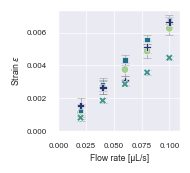

In [29]:
fsize = fsize_cm(4, 4)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.scatterplot(data=df_median_before,
                x='flow_rate', y=strain_feat + '_corr',
                hue='radius', palette='crest',
                style='radius',
                s=30, zorder=10, ax=ax
                )
ax.errorbar(df_median_before['flow_rate'], df_median_before[strain_feat + '_corr'],
            yerr=df_sem_before[strain_feat],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=3, capthick=0.4,
            zorder=1)
ax.set_xlim(0, 0.11)
ax.set_ylim(0)
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain $\varepsilon$")
# ax.legend(loc='upper left', bbox_to_anchor=[1, 1],
#           # ncol=4, fontsize=15,
#           # title="Radius [µm]", title_fontsize=16
#           )
# ax.legend([])
ax.legend_ = None

# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_strain_inlet.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

#### Fit the scaled corrected stress data

Fit linear model to scaled stress

In [30]:
x_feat = 'flow_rate'
y_feat = 'stress_corr_scaled'

x_data = df_median_before[x_feat].to_numpy()
y_data = df_median_before[y_feat].to_numpy()
ii = np.argsort(x_data)
x_data = x_data[ii]
y_data = y_data[ii]

model = LinearModel()
# use built-in default values for paras from lmfit
# cut the data because intitial guess is already so good
# that model.fit cannot estimate errors
paras = model.guess(y_data[:-9], x=x_data[:-9])
result = model.fit(y_data, paras, x=x_data)

In [31]:
print(result.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 20
    # variables        = 2
    chi-square         = 81.8946780
    reduced chi-square = 4.54970433
    Akaike info crit   = 32.1940347
    Bayesian info crit = 34.1854992
    R-squared          = 0.80522349
[[Variables]]
    slope:      145.464754 +/- 7.54130653 (5.18%) (init = 159.3058)
    intercept:  4.0492e-11 +/- 0.45611808 (1126426115657.96%) (init = -0.3409431)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.3015


In [32]:
r2 = 1 - result.redchi / np.var(y_data, ddof=2)
# print("R-squared = ", r2)
n = len(x_data)
p = len(paras) - 1
r2_adj = r2 - (1-r2) * p / (n-p-1)
# print("R-squared adjusted = ", r2_adj)

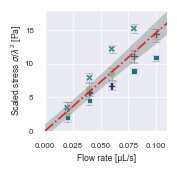

In [33]:
fsize = fsize_cm(4, 4)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_before,
                x=x_feat, y=y_feat,
                hue='radius', palette='crest',
                style='radius',
                s=30, zorder=3, ax=ax)
ax.errorbar(df_median_before['flow_rate'], df_median_before[y_feat],
            yerr=df_sem_before[y_feat],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=3, capthick=0.4,
            zorder=1)

# plot the 2-sigma error band
x_plot = np.linspace(0, 0.12, 100)
y_plot = result.eval(x=x_plot)
ax.plot(x_plot, y_plot, c='tab:red', ls='-.', 
        zorder=5,
        # label="best fit"
        )
# plot 2-sigma uncertainty interval
err_band = result.eval_uncertainty(x=x_plot, sigma=2)
ax.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                color='gray', alpha=.4, edgecolor='none',
                zorder=4,
                # label="2-$\sigma$ uncertainty"
                )
ax.set_xlim(0, 0.11)
ax.set_ylim(0, 18)

ax.set_xlabel(r"Flow rate [µL/s]")
ax.set_ylabel(r"Scaled stress $\sigma / \lambda^2$ [Pa]", labelpad=0.1)

# r2_adj_str = "$R^2_{adj}=$" + f"{r2_adj:.5f}"
# ax.text(0.005, 14.6, r2_adj_str, fontsize=7, va='top')
# str_fit_fct = r"$y = {:.1f}\cdot x + {:.1f}$".format(result.params['slope'].value,
#                                                      result.params['intercept'].value)
# ax.text(0.005, 15.5, str_fit_fct,
#          va='bottom', fontsize=7,
#          bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.7})

# handles, _ = ax.get_legend_handles_labels()
# labels = ["$E = 300\,$Pa", "$E = 1347\,$Pa", "$E = 1493\,$Pa",
#           "best fit", "2-$\sigma$ uncertainty"]
# l = ax.legend(loc='upper left', bbox_to_anchor=[1,1], fontsize=7, ncol=1)
ax.legend_ = None

# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_stress_inlet.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

Create legend manually for post-processing

In [34]:
handles, _ = ax.get_legend_handles_labels()
labels = ["5.5 / 300",
          "6.6 / 832",
          "7.3 / 379",
          "8.3 / 669"]

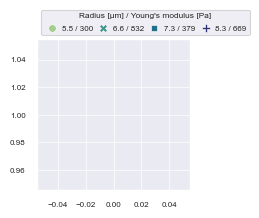

In [35]:
fsize = fsize_cm(5,5)
fig, ax_legend = plt.subplots(1, 1, figsize=fsize)
ax_legend.plot([0], [1])

ax_legend.legend(handles, labels, ncol=4, loc='lower left', bbox_to_anchor=[0,1],
                 title="Radius [µm] / Young's modulus [Pa]", title_fontsize=6,
                 columnspacing=0.3, handletextpad=0.2, labelspacing=0.8)

# save_path = "..\\figure_plots\\fig2_legend_stress_inlet_emodulus_radius.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

## Strain and stresses in the channel

In [36]:
df_medians_in = pd.read_csv("..\\data\\20231121_beads_outside_hyper\\20231121_medians_inlet_stress_measurements.tsv",
                            sep='\t', index_col=0)
df_medians_ch = pd.read_csv("..\\data\\20231121_beads_outside_hyper\\20231121_medians_channel_stress_measurements.tsv",
                            sep='\t', index_col=0)
df_sem_ch = pd.read_csv("..\\data\\20231121_beads_outside_hyper\\20240301_sem_channel_stress_measurements.tsv",
                        sep='\t', index_col=0)

##### Analyze the strain in the inlet to get the strain offset

In [37]:
df_medians_in['emodulus'] = df_medians_in['emodulus'].astype(int)
df_medians_in['radius'] = df_medians_in['radius'].round(decimals=1)
df_medians_in

sample region  flow_rate  Unnamed: 0  area_msd  area_ratio     area_um  \
0   S03_set1  inlet       0.02       491.0   1079.00    1.023876  126.930230   
1   S03_set1  inlet       0.04       487.5   1077.00    1.023495  126.757850   
2   S03_set1  inlet       0.06       488.0   1080.00    1.023899  127.045150   
3   S03_set1  inlet       0.08       457.0   1088.50    1.026219  128.654050   
4   S03_set1  inlet       0.10       427.0   1093.00    1.029224  129.228650   
5   S03_set2  inlet       0.01       260.0   1188.00    1.023034  139.456620   
6   S03_set2  inlet       0.02       492.0   1174.00    1.023276  138.077560   
7   S03_set2  inlet       0.04       495.0   1190.00    1.022652  139.743930   
8   S03_set2  inlet       0.06       471.0   1208.50    1.023729  142.214720   
9   S03_set2  inlet       0.08       467.5   1213.00    1.024694  142.846790   
10  S03_set2  inlet       0.10       476.5   1210.00    1.024155  142.473295   
11  S03_set3  inlet       0.01       227.5   1437.50    1.024132  168.933850   
12  S03_set3  inlet       0.02       488.5   1439.50    1.023630  169.278610   
13  S03_set3  inlet       0.04       487.0   1432.00    1.024703  168.589100   
14  S03_set3  inlet       0.06       493.0   1435.00    1.024604  168.761470   
15  S03_set3  inlet       0.08       493.0   1436.50    1.024188  168.876390   
16  S03_set3  inlet       0.10       492.5   1440.75    1.024382  169.336070   
17  S03_set4  inlet       0.01        52.0   1501.00    1.028663  177.265620   
18  S03_set4  inlet       0.02       103.0   1494.00    1.029481  176.633560   
19  S03_set4  inlet       0.04       233.5   1498.50    1.028470  177.093250   
20  S03_set4  inlet       0.06       238.5   1511.50    1.028216  178.271180   
21  S03_set4  inlet       0.08       243.5   1520.50    1.027418  179.678960   
22  S03_set4  inlet       0.10       242.5   1528.25    1.026941  180.655790   
23        S4  inlet       0.01       347.0    820.50    1.040665   98.085060   
24        S4  inlet       0.02       392.5    811.25    1.040855   97.022045   
25        S4  inlet       0.04       390.0    812.00    1.040736   97.165695   
26        S4  inlet       0.06       402.5    814.50    1.040545   97.510460   
27        S4  inlet       0.08       392.0    815.50    1.040676   97.452995   
28        S4  inlet       0.10       374.0    825.50    1.040932   98.659670   

    aspect  bright_avg  bright_sd  ...  strain_inert  net_strain_ell  \
0    1.000  136.602890   3.041065  ...      0.002780        0.006805   
1    1.000  136.671030   3.050058  ...      0.003569        0.007036   
2    1.000  136.565370   3.038305  ...      0.003895        0.007380   
3    1.000  137.089280   2.995502  ...      0.004896        0.008693   
4    1.025  137.190430   2.966294  ...      0.005554        0.010009   
5    1.000  135.709920   3.094782  ...      0.003090        0.006783   
6    1.000  135.571430   3.094363  ...      0.003428        0.007424   
7    1.000  136.080250   3.095919  ...      0.003607        0.006774   
8    1.000  136.406040   3.063279  ...      0.004467        0.007901   
9    1.000  136.476050   3.018728  ...      0.005200        0.008672   
10   1.000  136.361085   3.041512  ...      0.005021        0.008393   
11   1.000  136.955675   2.988593  ...      0.002879        0.006564   
12   1.000  136.910225   2.981981  ...      0.002623        0.006297   
13   1.000  137.117520   2.980247  ...      0.003309        0.006978   
14   1.000  137.148090   2.969847  ...      0.004540        0.007514   
15   1.000  137.178540   2.971752  ...      0.004912        0.007462   
16   1.000  137.259975   2.975423  ...      0.005841        0.008304   
17   1.000  137.921950   2.933255  ...      0.002317        0.006815   
18   1.000  137.749850   2.925707  ...      0.002224        0.007487   
19   1.000  137.958600   2.929130  ...      0.002561        0.007145   
20   1.000  137.996255   2.918829  ...      0.004097        0.007578   
21   1.000  137.96847

##### Correct the offset for S03 beads
Only use flow rates > 0.01 µL/s

In [38]:
df_in_s03 = df_medians_in.loc[(df_medians_in['emodulus'] > 1000) 
                              & (df_medians_in['flow_rate'] > 0.01)]

Fit linear model to strain of S03 beads in inlet

In [39]:
x_data = df_in_s03['flow_rate']
y_data = df_in_s03[strain_feat]

model = LinearModel()
# use built-in default values for paras from lmfit
paras = model.guess(y_data, x=x_data)
result = model.fit(y_data, paras, x=x_data)

In [40]:
print(result.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 20
    # variables        = 2
    chi-square         = 2.5486e-06
    reduced chi-square = 1.4159e-07
    Akaike info crit   = -313.513603
    Bayesian info crit = -311.522138
    R-squared          = 0.89202292
[[Variables]]
    slope:      0.03627581 +/- 0.00297481 (8.20%) (init = 0.03627581)
    intercept:  0.00198409 +/- 1.9733e-04 (9.95%) (init = 0.001984085)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9045


In [41]:
r2 = 1 - result.redchi / np.var(y_data, ddof=2)
n = len(x_data)
p = len(paras) - 1
r2_adj = r2 - (1-r2) * p / (n-p-1)

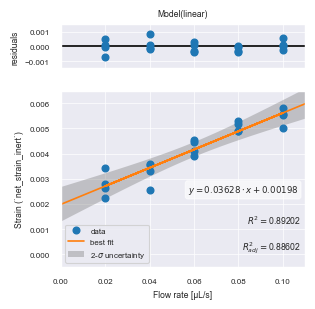

In [42]:
fig = plt.figure(0, figsize=fsize_cm(8,8))
result.plot(xlabel='Flow rate [µL/s]',
            ylabel=r"Strain (`net_strain_inert`)",
            fig=fig
            )
ax1, ax2 = fig.axes
ax1.set_ylim(-0.0015, 0.0015)

# plot the 2-sigma error band
x_plot = np.linspace(0, 0.11, 100)
y_plot = result.eval(x=x_plot)
err_band = result.eval_uncertainty(x=x_plot, sigma=3)
ax2.plot(x_plot, y_plot, c='C1')
ax2.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                 color="gray", alpha=.4, edgecolor='none',
                 zorder=1,
                 label='2-$\sigma$ uncertainty')
ax2.set_xlim(0, 0.11)
ax2.set_ylim(-0.0005, 0.0065)

r2_str = f"$R^2=${r2:.5f}"
ax2.text(0.108, 0.0012, r2_str, ha='right')
r2_adj_str = "$R^2_{adj}=$" + f"{r2_adj:.5f}"
ax2.text(0.108, 0.0002, r2_adj_str, ha='right')
str_fit_fct = r"$y = {:.5f}\cdot x + {:.5f}$".format(result.params['slope'].value,
                                                     result.params['intercept'].value)
ax2.text(0.107, 0.0023, str_fit_fct,
         va='bottom', ha='right',
         bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.6})
ax2.legend(loc='lower left')
plt.show()

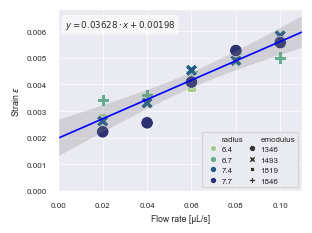

In [43]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.scatterplot(data=df_in_s03,
                x='flow_rate', y=strain_feat,
                hue='radius', palette='crest',
                style='emodulus',
                linewidth=0.5,
                s=80, ax=ax, legend='full'
                )
ax.plot(x_plot, y_plot, c='blue')
ax.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                color="gray", alpha=.25, edgecolor='none',
                zorder=1,
                # label='2-$\sigma$ uncertainty'
                )

ax.set_xlim(0, 0.11)
ax.set_ylim(0)
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain $\varepsilon$")

str_fit_fct = r"$y = {:.5f}\cdot x + {:.5f}$".format(result.params['slope'].value,
                                                     result.params['intercept'].value)
ax.text(0.003, 0.006, str_fit_fct,
        va='bottom', ha='left',
        bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.6})

ax.legend(loc='lower right', #bbox_to_anchor=[1, 1],
          ncol=2, columnspacing=0.1, handletextpad=0.1,
          markerscale=0.5,
          #, fontsize=15,
          # title="Radius [µm]", title_fontsize=16
          )
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s2_strain_correction_s03.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

Correct the strain of the S03 beads in `df_medians_ch` by 0.00198

In [44]:
ict_s4_12um = df_fit_paras.loc[df_fit_paras['emodulus'] == 300]['intercept'].values[0]
ict_s03 = 0.00198

In [45]:
dict_delta_strain = {}
for key in df_medians_ch['emodulus'].unique():
    if float(key) < 1000:
        dict_delta_strain[key] = ict_s4_12um
    elif float(key) > 1000:
        dict_delta_strain[key] = ict_s03
    else:
        pass
dict_delta_strain

{1819.158: 0.00198,
 1846.042: 0.00198,
 1493.447: 0.00198,
 1346.692: 0.00198,
 300.0: 0.0034463266257140504}

In [46]:
df_medians_ch['delta_strain'] = df_medians_ch['emodulus'].map(dict_delta_strain)

In [47]:
df_medians_ch[strain_feat + '_corr'] = df_medians_ch[strain_feat] \
                                       - df_medians_ch['delta_strain']
df_medians_ch['stress_corr'] = df_medians_ch[strain_feat + '_corr'] \
                               * df_medians_ch['emodulus']
n_scaling = 2
df_medians_ch['stress_corr_scaled'] = df_medians_ch['stress_corr'] \
                                      / (df_medians_ch['confinement'] ** n_scaling)

df_sem_ch['stress_corr'] = df_sem_ch[strain_feat] * df_sem_ch['emodulus']
df_sem_ch['stress_corr_scaled'] = (df_sem_ch['stress_corr'] 
                                   / (df_medians_ch['confinement'] ** n_scaling))

In [48]:
df_medians_ch['emodulus'] = df_medians_ch['emodulus'].astype(int)
df_medians_ch['radius'] = df_medians_ch['radius'].round(decimals=1)
df_medians_ch

sample   region  flow_rate  Unnamed: 0  area_msd  area_ratio  \
0   S03_set1  channel       0.01       491.5   1074.50    1.023875   
1   S03_set1  channel       0.02       494.0   1077.50    1.023798   
2   S03_set1  channel       0.04       496.0   1073.50    1.023655   
3   S03_set1  channel       0.06       494.0   1076.50    1.023108   
4   S03_set1  channel       0.08       495.0   1075.50    1.023574   
5   S03_set1  channel       0.10       497.0   1071.00    1.024201   
6   S03_set2  channel       0.01       495.0   1198.50    1.022689   
7   S03_set2  channel       0.02       491.0   1197.00    1.022541   
8   S03_set2  channel       0.04       492.5   1201.75    1.022644   
9   S03_set2  channel       0.06       493.5   1195.50    1.023030   
10  S03_set2  channel       0.08       493.0   1192.50    1.023425   
11  S03_set2  channel       0.10       491.5   1190.50    1.023779   
12  S03_set3  channel       0.01       490.0   1433.00    1.024501   
13  S03_set3  channel       0.02       491.5   1443.75    1.023797   
14  S03_set3  channel       0.04       492.5   1443.00    1.024815   
15  S03_set3  channel       0.06       490.0   1436.50    1.025291   
16  S03_set3  channel       0.08       483.5   1434.75    1.026293   
17  S03_set3  channel       0.10       482.5   1445.00    1.025038   
18  S03_set4  channel       0.01        50.5   1552.00    1.025304   
19  S03_set4  channel       0.02       106.5   1545.25    1.024796   
20  S03_set4  channel       0.04       230.0   1555.00    1.024820   
21  S03_set4  channel       0.06       241.0   1555.50    1.025238   
22  S03_set4  channel       0.08       243.0   1548.50    1.026462   
23  S03_set4  channel       0.10       246.5   1575.50    1.023994   
24        S4  channel       0.01       381.5    816.00    1.040725   
25        S4  channel       0.02       395.5    817.50    1.040457   
26        S4  channel       0.04       380.0    815.50    1.040954   
27        S4  channel       0.06       384.5    816.00    1.041390   
28        S4  channel       0.08       378.0    818.00    1.041159   
29        S4  channel       0.10       356.5    819.00    1.041487   

       area_um    aspect  bright_avg  bright_sd  ...  net_strain_inert  \
0   126.355630  1.000000  136.949315   3.077794  ...          0.004350   
1   126.700390  1.000000  136.860350   3.085475  ...          0.006501   
2   126.355630  1.000000  137.063660   3.097364  ...          0.009230   
3   126.642930  1.000000  137.187060   3.100109  ...          0.012359   
4   126.585470  1.025641  137.229640   3.089596  ...          0.015651   
5   126.068320  1.026316  136.961670   3.125287  ...          0.018027   
6   140.778210  1.000000  136.505690   3.071700  ...          0.004750   
7   140.375990  1.000000  136.403200   3.090097  ...          0.006703   
8   141.065500  1.000000  136.428385   3.100241  ...          0.010592   
9   140.375990  1.024390  136.492685   3.120297  ...          0.013827   
10  140.146150  1.025000  136.332230   3.119676  ...          0.017408   
11  140.031220  1.025000  136.343595   3.126938  ...          0.020749   
12  168.531630  1.000000  137.491130   2.969993  ...          0.005110   
13  169.738300  1.000000  137.290365   2.961720  ...          0.008752   
14  169.565920  1.022222  137.041320   2.970558  ...          0.014842   
15  168.991320  1.022727  137.014940   2.982245  ...          0.019454   
16  168.991320  1.023256  137.409990   2.995948  ...          0.025729   
17  170.226715  1.023256  137.431440   2.985932  ...          0.030196   
18  182.494530  1.000000  139.145860   2.943159  ...          0.006312   
19  181.575160  1.000000  139.098635   2.964046  ...          0.009999   
20  183.011670  1.021739  139.181430   2.969621  ...          0.015944   
21  183.184050  1.022222  139.099750   2.977673  ...          0.022869   
22  182.322140  1.022222  139.020280   2.985211  ...          0.029618   
23  185.425020  1.042553  139.289770   2.991009  ...       

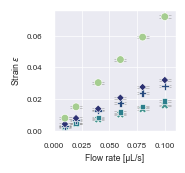

In [49]:
fsize = fsize_cm(4, 4)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.scatterplot(data=df_medians_ch,
                x='flow_rate', y=strain_feat + '_corr',
                hue='radius', palette='crest',
                style='radius',
                s=30, zorder=5, ax=ax
                )
ax.errorbar(df_medians_ch['flow_rate'], df_medians_ch[strain_feat + '_corr'],
            yerr=df_sem_ch[strain_feat],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=4, capthick=0.4,
            zorder=1)

ax.set_xlim(0, 0.11)
ax.set_ylim(0)
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain $\varepsilon$")
# ax.legend(loc='upper left', bbox_to_anchor=[1, 1],
#           ncol=2, columnspacing=0.1, handletextpad=0.1,
#           #, fontsize=15,
#           # title="Radius [µm]", title_fontsize=16
#           )
ax.legend_ = None

# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_strain_channel.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

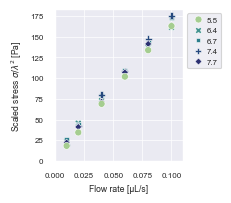

In [50]:
fsize = fsize_cm(4.2, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)
sns.scatterplot(data=df_medians_ch,
                x='flow_rate', y='stress_corr_scaled',
                hue='radius', palette='crest',
                style='radius',
                s=25, ax=ax
                )
ax.set_xlim(0, 0.11)
ax.set_ylim(0)
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Scaled stress $\sigma / \lambda^2$ [Pa]")
ax.legend(loc='upper left', bbox_to_anchor=[1, 1],
          ncol=1, columnspacing=0.1, handletextpad=0.1,
          #, fontsize=15,
          # title="Radius [µm]", title_fontsize=16
          )
plt.show()

In [51]:
df_medians_ch['radius'].dtype

dtype('float64')

#### Fit power law on scaled corrected stress

In [52]:
x_feat = 'flow_rate'
y_feat = 'stress_corr_scaled'

x_data = df_medians_ch[x_feat].to_numpy()
y_data = df_medians_ch[y_feat].to_numpy()
ii_sort = np.argsort(x_data)
x_data = x_data[ii_sort]
y_data = y_data[ii_sort]
# power law can only fit positive value
idx_pos = 0 < y_data
x_data = x_data[idx_pos]
y_data = y_data[idx_pos]

model = PowerLawModel()
# use built-in default values for paras from lmfit
paras = model.guess(y_data, x=x_data)
result = model.fit(y_data, paras, x=x_data)

In [53]:
print(result.fit_report())

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 30
    # variables        = 2
    chi-square         = 564.400188
    reduced chi-square = 20.1571496
    Akaike info crit   = 92.0369852
    Bayesian info crit = 94.8393799
    R-squared          = 0.99300037
[[Variables]]
    amplitude:  1282.68817 +/- 67.0953638 (5.23%) (init = 1299.975)
    exponent:   0.88197720 +/- 0.01998246 (2.27%) (init = 0.8871446)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = +0.9889


In [54]:
r2 = 1 - result.redchi / np.var(y_data, ddof=2)
# print("R-squared = ", r2)
n = len(x_data)
p = len(paras) - 1
r2_adj = r2 - (1-r2) * p / (n-p-1)
# print("R-squared adjusted = ", r2_adj)

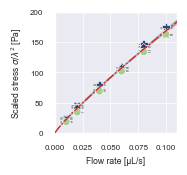

In [55]:
fsize = fsize_cm(4, 4)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_medians_ch,
                x=x_feat, y=y_feat,
                hue='radius', palette='crest',
                style='radius',
                s=30, zorder=3, ax=ax)
ax.errorbar(df_medians_ch['flow_rate'], df_medians_ch[y_feat],
            yerr=df_sem_ch[y_feat],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=4, capthick=0.4,
            zorder=1)

# plot the 2-sigma error band
x_plot = np.linspace(0, 0.12, 100)
y_plot = result.eval(x=x_plot)
ax.plot(x_plot, y_plot, c='tab:red', ls='-.', lw=1,
        zorder=4,
        # label="best fit"
        )
sigma = 2
err_band = result.eval_uncertainty(x=x_plot, sigma=sigma)
ax.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                color="gray", alpha=.6, edgecolor='none',
                zorder=1,
                # label="{}-$\sigma$ uncertainty".format(sigma)
                )
ax.set_xlim(0, 0.11)
ax.set_ylim(0, 200)

ax.set_xlabel(r"Flow rate [µL/s]")
ax.set_ylabel(r"Scaled stress $\sigma / \lambda^2$ [Pa]")

# ax.legend(loc='upper left', bbox_to_anchor=[1, 1],
#           ncol=2, columnspacing=0.1, handletextpad=0.1,
#           #, fontsize=15,
#           # title="Radius [µm]", title_fontsize=16
#           )
ax.legend_ = None

# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_stress_channel.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

Create a manual legend to add in post-processing

In [56]:
handles, _ = ax.get_legend_handles_labels()
labels = ["5.5 / 300",
          "6.4 / 1819",
          "6.7 / 1846",
          "7.4 / 1493",
          "7.7 / 1347"
          ]

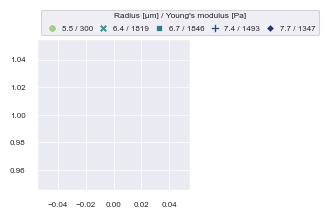

In [57]:
fsize = fsize_cm(5,5)
fig, ax_legend = plt.subplots(1, 1, figsize=fsize)
ax_legend.plot([0], [1])

ax_legend.legend(handles, labels, ncol=5, loc='lower left', bbox_to_anchor=[0,1],
                 title="Radius [µm] / Young's modulus [Pa]", title_fontsize=6,
                 columnspacing=0.3, handletextpad=0.2, labelspacing=0.8)

# save_path = "..\\figure_plots\\fig2_legend_stress_channel_emodulus_radius.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

## Create grouped data by stress per bead in hyperbolic region
Use "stable" values between 250-325 µm

In [58]:
x_min = 250
x_max = 325
idx = (x_min < df_wc60_lc500['x_hyper']) & (df_wc60_lc500['x_hyper'] < x_max)
# feature to group by
df_stable = df_wc60_lc500.loc[idx]
df_median_objnr = df_stable.groupby(by=['sample', 'flow_rate', 'object_number'], as_index=False).median()
df_median_objnr['stress'] = df_median_objnr['net_strain_inert'] * df_median_objnr['emodulus']

Add strain correction based on strain offset determined in `20231108_paa_beads_outside_hyper_net_strain_inert.ipynb`

In [59]:
dict_delta_strain = {'S03 Set3': 0.00198,
                     'S03 Set4': 0.00198,
                     'S4': 0.0034463266257165684}

In [60]:
df_median_objnr['delta_strain'] = df_median_objnr['sample'].map(dict_delta_strain)
df_median_objnr['net_strain_inert_corr'] = df_median_objnr['net_strain_inert'] - df_median_objnr['delta_strain']
df_median_objnr['stress_corr'] = df_median_objnr['net_strain_inert_corr'] * df_median_objnr['emodulus']

Distributions for median values and mean values per bead are very similar but the distributions are clearly skewed to higher deformations for the S03 beads. –> Use the medians for the mean-bead strains to redo the stress analysis

In [61]:
gr_by = 'sample'
df_objects_median, df_objects_mean, df_objects_sem = get_stable_df(df_median_objnr, x_min, x_max, gr_by=gr_by)

In [62]:
df_objects_median

sample  flow_rate  object_number  Unnamed: 0  area_msd  area_ratio  \
0   S03 Set3       0.01          118.0    11615.50  1415.000    1.027553   
1   S03 Set3       0.02          176.5    10847.25  1386.500    1.030363   
2   S03 Set3       0.03          241.0    10489.00  1378.500    1.030931   
3   S03 Set3       0.04          358.5    12090.25  1380.500    1.031455   
4   S03 Set3       0.05          477.0    13483.00  1379.750    1.032200   
5   S03 Set3       0.06          571.0    13455.00  1379.000    1.032421   
6   S03 Set3       0.08          661.0    11797.00  1381.750    1.033468   
7   S03 Set3       0.10          824.0    11849.00  1388.000    1.033112   
8   S03 Set3       0.12          914.5    11193.75  1417.500    1.029532   
9   S03 Set3       0.14         1015.5    10443.00  1416.000    1.031196   
10  S03 Set4       0.01           64.5     6422.75  1530.000    1.025787   
11  S03 Set4       0.02          126.0     7448.00  1511.875    1.028600   
12  S03 Set4       0.03          172.0     7410.00  1534.000    1.026422   
13  S03 Set4       0.04          243.5     7257.75  1519.875    1.028058   
14  S03 Set4       0.05          301.0     7589.00  1515.500    1.029931   
15  S03 Set4       0.06          330.0     6965.50  1486.750    1.032616   
16  S03 Set4       0.08          462.0     7546.50  1482.000    1.034335   
17  S03 Set4       0.10          548.5     7066.50  1494.000    1.033975   
18  S03 Set4       0.12          490.0     5298.00  1486.500    1.035148   
19  S03 Set4       0.14          367.0     3133.00  1483.000    1.036355   
20        S4       0.01          215.0    24523.50   808.500    1.042046   
21        S4       0.02          387.5    21491.00   790.750    1.044064   
22        S4       0.03          587.5    21756.00   792.000    1.044518   
23        S4       0.04          813.0    24041.25   794.000    1.044732   
24        S4       0.05         1071.0    25941.50   796.625    1.045121   
25        S4       0.06         1313.0    25328.50   815.500    1.043998   
26        S4       0.07         1277.5    21673.25   804.000    1.045455   
27        S4       0.08         1465.5    21796.00   820.000    1.044432   
28        S4       0.09         1404.5    18908.25   827.500    1.044113   
29        S4       0.10         1511.0    18346.75   831.750    1.044093   
30        S4       0.12         1420.5    14003.75   835.750    1.044379   
31        S4       0.14         1375.0    11678.25   842.500    1.044522   

       area_um    aspect  bright_avg  bright_sd  ...  strain_inert  \
0   167.095120  1.000000  130.489930   2.927381  ...      0.009027   
1   164.193360  1.000000  129.942235   2.937490  ...      0.010402   
2   163.072880  1.011364  129.609790   2.942899  ...      0.014922   
3   163.618758  1.022992  129.526725   2.940040  ...      0.023372   
4   163.503835  1.023256  129.263760   2.934851  ...      0.030804   
5   163.561290  1.045454  129.267680   2.931095  ...      0.039138   
6   163.819870  1.047619  129.186735   2.941679  ...      0.052326   
7   164.509400  1.069767  129.247630   2.950011  ...      0.065683   
8   167.612260  1.071428  129.492993   2.950001  ...      0.079109   
9   167.569167  1.093023  129.254600   2.952539  ...      0.093434   
10  180.267938  1.000000  130.346255   2.926627  ...      0.010788   
11  178.659045  1.000000  129.713295   2.927139  ...      0.012896   
12  181.115480  1.022222  129.646990   2.910905  ...      0.022010   
13  179.635865  1.022222  129.418508   2.924912  ...      0.029465   
14  179.334200  1.034091  129.263260   2.924534  ...      0.038733   
15  176.403720  1.045454  128.886405   2.915085  ...      0.046289   
16  176.001500  1.066667  128.846710   2.922286  ...      0.063846   
17  177.653482  1.069767  128.983808   2.932756  ...      0.079249   
18  176.719750  1.090909  128.854995   2.937276  ...      0.094713   
19  176.748470  1.100000  128.752955   2.953321  ...      0.113317   
20   96.820930  1.000000  1

### Only include data with $\varepsilon < 0.125$

- Also exclude datapoint for S03 beads at 0.01 µL/s <-- strain values dominated by noise
- At larger strains no more linear relationship between stress and strain --> expected for PAAm beads
- Analysis for higher extension rates seems valid for this analysis, only small strains important

In [63]:
filter_idx_median = df_objects_median['net_strain_inert_corr'] < 0.125
df_median_filtered = df_objects_median.loc[filter_idx_median]
df_sem_filtered = df_objects_sem.loc[filter_idx_median]
# remove rows for S03 beads at 0.01 ul/s
df_median_filtered \
    = df_median_filtered.drop(df_median_filtered[(df_median_filtered['sample'] == 'S03 Set3')
                                                 & (df_median_filtered['flow_rate'] == 0.01)].index)
df_median_filtered \
    = df_median_filtered.drop(df_median_filtered[(df_median_filtered['sample'] == 'S03 Set4')
                                                 & (df_median_filtered['flow_rate'] == 0.01)].index)

df_sem_filtered \
    = df_sem_filtered.drop(df_sem_filtered[(df_sem_filtered['sample'] == 'S03 Set3')
                                           & (df_sem_filtered['flow_rate'] == 0.01)].index)
df_sem_filtered \
    = df_sem_filtered.drop(df_sem_filtered[(df_sem_filtered['sample'] == 'S03 Set4')
                                           & (df_sem_filtered['flow_rate'] == 0.01)].index)

In [64]:
df_median_filtered

sample  flow_rate  object_number  Unnamed: 0  area_msd  area_ratio  \
1   S03 Set3       0.02          176.5    10847.25  1386.500    1.030363   
2   S03 Set3       0.03          241.0    10489.00  1378.500    1.030931   
3   S03 Set3       0.04          358.5    12090.25  1380.500    1.031455   
4   S03 Set3       0.05          477.0    13483.00  1379.750    1.032200   
5   S03 Set3       0.06          571.0    13455.00  1379.000    1.032421   
6   S03 Set3       0.08          661.0    11797.00  1381.750    1.033468   
7   S03 Set3       0.10          824.0    11849.00  1388.000    1.033112   
8   S03 Set3       0.12          914.5    11193.75  1417.500    1.029532   
9   S03 Set3       0.14         1015.5    10443.00  1416.000    1.031196   
11  S03 Set4       0.02          126.0     7448.00  1511.875    1.028600   
12  S03 Set4       0.03          172.0     7410.00  1534.000    1.026422   
13  S03 Set4       0.04          243.5     7257.75  1519.875    1.028058   
14  S03 Set4       0.05          301.0     7589.00  1515.500    1.029931   
15  S03 Set4       0.06          330.0     6965.50  1486.750    1.032616   
16  S03 Set4       0.08          462.0     7546.50  1482.000    1.034335   
17  S03 Set4       0.10          548.5     7066.50  1494.000    1.033975   
18  S03 Set4       0.12          490.0     5298.00  1486.500    1.035148   
19  S03 Set4       0.14          367.0     3133.00  1483.000    1.036355   
20        S4       0.01          215.0    24523.50   808.500    1.042046   
21        S4       0.02          387.5    21491.00   790.750    1.044064   
22        S4       0.03          587.5    21756.00   792.000    1.044518   
23        S4       0.04          813.0    24041.25   794.000    1.044732   
24        S4       0.05         1071.0    25941.50   796.625    1.045121   

       area_um    aspect  bright_avg  bright_sd  ...  strain_inert  \
1   164.193360  1.000000  129.942235   2.937490  ...      0.010402   
2   163.072880  1.011364  129.609790   2.942899  ...      0.014922   
3   163.618758  1.022992  129.526725   2.940040  ...      0.023372   
4   163.503835  1.023256  129.263760   2.934851  ...      0.030804   
5   163.561290  1.045454  129.267680   2.931095  ...      0.039138   
6   163.819870  1.047619  129.186735   2.941679  ...      0.052326   
7   164.509400  1.069767  129.247630   2.950011  ...      0.065683   
8   167.612260  1.071428  129.492993   2.950001  ...      0.079109   
9   167.569167  1.093023  129.254600   2.952539  ...      0.093434   
11  178.659045  1.000000  129.713295   2.927139  ...      0.012896   
12  181.115480  1.022222  129.646990   2.910905  ...      0.022010   
13  179.635865  1.022222  129.418508   2.924912  ...      0.029465   
14  179.334200  1.034091  129.263260   2.924534  ...      0.038733   
15  176.403720  1.045454  128.886405   2.915085  ...      0.046289   
16  176.001500  1.066667  128.846710   2.922286  ...      0.063846   
17  177.653482  1.069767  128.983808   2.932756  ...      0.079249   
18  176.719750  1.090909  128.854995   2.937276  ...      0.094713   
19  176.748470  1.100000  128.752955   2.953321  ...      0.113317   
20   96.820930  1.000000  130.764495   2.717078  ...      0.023726   
21   94.867280  1.030303  130.111650   2.717984  ...      0.048419   
22   94.982200  1.061553  130.054425   2.733824  ...      0.074486   
23   95.240768  1.093750  129.961232   2.730839  ...      0.104707   
24   95.642993  1.125000  129.897947   2.740576  ...      0.133375   

    net_strain_ell  net_strain_ell_corr  net_strain_inert  taylor_strain_ell  \
1         0.012126             0.011188          0.010348           0.006063   
2         0.016399             0.015351          0.014812           0.008199   
3         0.024006             0.023152          0.023103           0.012002   
4         0.031328             0.030296          0.030340           0.015662   
5         0.039548             0.038639          0.038394           0.019770   
6         0.052167  

Calculate first normal stress difference corrected for influence of shear stress

In [65]:
df_median_filtered['n1_shear_corrected'] = df_median_filtered['stress'] - df_median_filtered['shear_stress']
df_median_filtered['n1_corr_shear_corrected'] = df_median_filtered['stress_corr'] \
                                                - df_median_filtered['shear_stress']

df_sem_filtered['n1_shear_corrected'] = df_sem_filtered['stress'] + df_sem_filtered['shear_stress']
df_sem_filtered['n1_corr_shear_corrected'] = df_sem_filtered['stress_corr'] + df_sem_filtered['shear_stress']

#### Only concentrate on results from median, corrected stress values

In [66]:
df_median_filtered['extension_rate_sample'] = np.abs(df_median_filtered['extension_rate_sample'])

In [67]:
df_median_filtered['extensional_viscosity'] = df_median_filtered['n1_shear_corrected'] \
                                             / df_median_filtered['extension_rate_sample']
df_median_filtered['extensional_viscosity_corr'] = df_median_filtered['n1_corr_shear_corrected'] \
                                                   / df_median_filtered['extension_rate_sample']

df_sem_filtered['extensional_viscosity'] = df_sem_filtered['n1_shear_corrected'] \
                                           / df_median_filtered['extension_rate_sample']
df_sem_filtered['extensional_viscosity_corr'] = df_sem_filtered['n1_corr_shear_corrected'] \
                                                / df_median_filtered['extension_rate_sample']

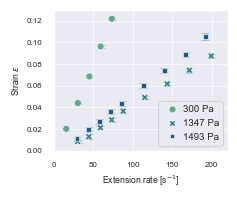

In [68]:
fsize = fsize_cm(6,5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_filtered,
                x='extension_rate_sample', y='net_strain_inert_corr',
                hue='sample', palette='crest',
                style='sample',
                hue_order=['S4', 'S03 Set3', 'S03 Set4'],
                style_order=['S4', 'S03 Set3', 'S03 Set4'],
                s=25, zorder=3, ax=ax)
ax.errorbar(df_median_filtered['extension_rate_sample'], df_median_filtered['net_strain_inert_corr'],
            yerr=df_sem_filtered['net_strain_inert_corr'],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=3, capthick=0.4,
            zorder=1)

ax.set_xlim(0, 220)
ax.set_ylim(0, 0.13)

ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])

ax.set_xlabel("Extension rate [s$^{-1}$]")
ax.set_ylabel(r"Strain $\varepsilon$")

handles, _ = ax.get_legend_handles_labels()
labels = ['300 Pa', '1347 Pa', '1493 Pa']
l = ax.legend(handles, labels, 
              loc='lower right', #bbox_to_anchor=[1, 0],
              ncol=1, columnspacing=0.1, handletextpad=0.1,
              # title="Young's modulus", title_fontsize=7, 
              fontsize=7)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_strain_extension_rate.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

#### Fit power law to corrected $N_1$ curve

In [69]:
x_feat = 'extension_rate_sample'
y_feat = 'n1_corr_shear_corrected'

x_data = df_median_filtered[x_feat]
y_data = df_median_filtered[y_feat]

model = PowerLawModel()
# use built-in default values for paras from lmfit
paras = model.guess(y_data, x=x_data)
result = model.fit(y_data, paras, x=x_data)

In [70]:
print(result.fit_report())

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 23
    # variables        = 2
    chi-square         = 321.089060
    reduced chi-square = 15.2899553
    Akaike info crit   = 64.6331593
    Bayesian info crit = 66.9041477
    R-squared          = 0.98428634
[[Variables]]
    amplitude:  0.15516942 +/- 0.03476209 (22.40%) (init = 0.08783545)
    exponent:   1.22505126 +/- 0.04479300 (3.66%) (init = 1.344059)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -0.9973


In [71]:
r2 = 1 - result.redchi / np.var(y_data, ddof=2)
print("R-squared = ", r2)
n = len(x_data)
p = len(paras) - 1
r2_adj = r2 - (1-r2) * p / (n-p-1)
print("R-squared adjusted = ", r2_adj)

R-squared =  0.984286335514286
R-squared adjusted =  0.9835380657768711


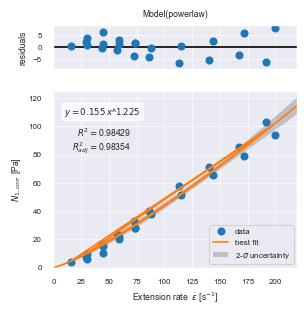

In [72]:
fig = plt.figure(0, figsize=fsize_cm(8,8))
result.plot(xlabel=r"Extension rate  $\dot\varepsilon$ [s$^{-1}$]",
            ylabel=r"$N_{1, corr}$ [Pa]",
            fig=fig
            )
ax1, ax2 = fig.axes
ax1.set_ylim(-9, 9)

# plot the 2-sigma error band
x_plot = np.linspace(0, 250, 100)
y_plot = result.eval(x=x_plot)
err_band = result.eval_uncertainty(x=x_plot, sigma=2)
ax2.plot(x_plot, y_plot, c='C1')
ax2.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                 color="gray", alpha=.4, edgecolor='none',
                 zorder=1,
                 label='2-$\sigma$ uncertainty')
ax2.set_xlim(0, 220)
ax2.set_ylim(0, 125)

r2_str = f"$R^2=${r2:.5f}"
ax2.text(70, 100, r2_str, ha='right', va='top')
r2_adj_str = "$R^2_{adj}=$" + f"{r2_adj:.5f}"
ax2.text(70, 90, r2_adj_str, ha='right', va='top')
ampl = result.params['amplitude'].value
expnt = result.params['exponent'].value
str_fit_fct = r"$y = {:.3f}\,x$^${:.3f}$".format(ampl, expnt)
ax2.text(10, 115, str_fit_fct,
         ha='left', va='top',
         bbox={'facecolor': 'w', 'boxstyle': 'round', 'alpha': 0.7})
ax2.legend(loc='lower right')
plt.show()

Plot with Youngs modulus as hue

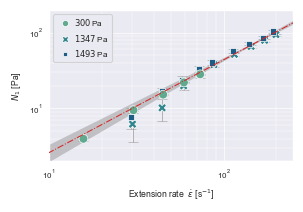

In [154]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_filtered,
                x=x_feat, y=y_feat,
                hue='sample', palette='crest',
                style='sample',
                hue_order=['S4', 'S03 Set3', 'S03 Set4'],
                style_order=['S4', 'S03 Set3', 'S03 Set4'],
                s=40, zorder=3, ax=ax)
ax.errorbar(df_median_filtered[x_feat], df_median_filtered[y_feat],
            yerr=df_sem_filtered[y_feat],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=3.5, capthick=0.4,
            zorder=1)

# plot the 2-sigma error band
x_plot = np.linspace(0, 250, 100)
y_plot = result.eval(x=x_plot)
ax.plot(x_plot, y_plot, c='tab:red', ls='-.', lw=0.75, zorder=4)
# plot 2-sigma uncertainty interval
err_band = result.eval_uncertainty(x=x_plot, sigma=2)
ax.fill_between(x_plot, y_plot-err_band, y_plot+err_band,
                 color='gray', alpha=.4, edgecolor='none',
                 zorder=1,
                 label="2-$\sigma$ uncertainty")
ax.set(xscale='log', yscale='log')
ax.set_xlim(10, 250)
ax.set_ylim(2, 200)
ax.grid(which='minor', linewidth=0.3)
ax.tick_params(axis='both', which='major', pad=0)
ax.tick_params(axis='both', which='minor')

ax.set_xlabel(r"Extension rate  $\dot\varepsilon$ [s$^{-1}$]")
ax.set_ylabel(r"$N_{1}$ [Pa]")

handles, _ = ax.get_legend_handles_labels()
labels = ["$300\,$Pa", "$1347\,$Pa", "$1493\,$Pa", 
          "best fit", "2-$\sigma$ uncertainty"]
ax.legend(handles[:3], labels[:3], loc='upper left', 
          fontsize=6, 
          markerscale=0.7,
          handletextpad=0.1, labelspacing=0.5, borderpad=0.4
          )
# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig2_stress_extension_rate.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

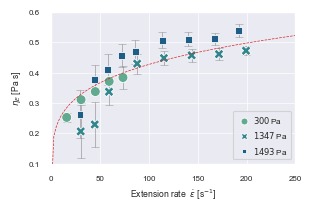

In [74]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.scatterplot(data=df_median_filtered,
                x=x_feat, y='extensional_viscosity_corr',
                hue='sample', palette='crest',
                style='sample',
                hue_order=['S4', 'S03 Set3', 'S03 Set4'],
                style_order=['S4', 'S03 Set3', 'S03 Set4'],
                s=50, zorder=3, ax=ax)
ax.errorbar(df_median_filtered[x_feat], df_median_filtered['extensional_viscosity_corr'],
            yerr=df_sem_filtered['extensional_viscosity_corr'],
            lw=0, markersize=0, alpha=0.75,
            elinewidth=0.5, ecolor='gray', capsize=3, capthick=0.4,
            zorder=1)
# ax.set(xscale='log', yscale='log')

x_plot = np.linspace(0, 250, 100)
ax.plot(x_plot, 0.155*x_plot**0.22, '--', c='tab:red', lw=0.5, zorder=5)

ax.set_xlim(0, 250)
ax.set_ylim(0.1, 0.6)
# ax.set_ylim(0, 119)

ax.set_xlabel(r"Extension rate  $\dot\varepsilon$ [s$^{-1}$]")
ax.set_ylabel(r"$\eta_E$ [Pa s]")

handles, _ = ax.get_legend_handles_labels()
labels = ["$300\,$Pa", "$1347\,$Pa", "$1493\,$Pa",
          "best fit", "2-$\sigma$ uncertainty"]
ax.legend(handles[:3], labels[:3], loc='lower right',
          fontsize=6,
          markerscale=0.7,
          handletextpad=0.1, labelspacing=0.5, borderpad=0.4
          )
# plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\SI\\extensional_viscosity.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

## Plot stress over x

In [75]:
df_x_stress = pd.read_csv("..\\data\\20230725_paa_beads\\20240226_beads_median_data.tsv", sep='\t', index_col=0)
df_x_stress = df_x_stress.loc[(df_x_stress['sample'] == 's8_15um') & 
                              (-50 < df_x_stress['x_hyper']) & (df_x_stress['x_hyper'] < 490)]
df_x_stress_004 = df_x_stress.loc[df_x_stress['flow_rate'] == 0.04]

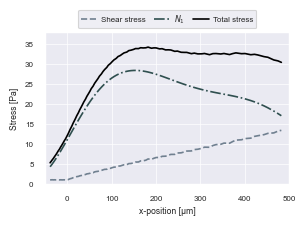

In [76]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

x = df_x_stress_004['x_hyper']
shear_stress = df_x_stress_004['shear_stress_net_ir']
normal_stress = df_x_stress_004['normal_stress_net_ir']
total_stress = df_x_stress_004['stress_net_ir']

ax.plot(x, shear_stress, c='slategray', ls='--', label="Shear stress")
ax.plot(x, normal_stress, c='darkslategray', ls='-.',label="$N_1$")
ax.plot(x, total_stress, c='k', ls='-',label="Total stress")

ax.set_xlim(-50, 500)
ax.set_ylim(0, 38)

ax.set_xlabel("x-position [µm]")
ax.set_ylabel("Stress [Pa]")

ax.legend(loc='lower center', bbox_to_anchor=[0.5, 1], 
          ncol=3, handletextpad=0.5, columnspacing=1.0
          )
plt.show()

save_path = "..\\figure_plots\\fig2_stress_over_x.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

## Supplement: plot boxplots of strain distributions to get better impression of data spread
### Strain in inlet and channel
#### Inlet

C:\Users\freiche\AppData\Local\Temp\ipykernel_37280\971580240.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['radius_plot'] = np.round(df_analysis['radius'], 1)


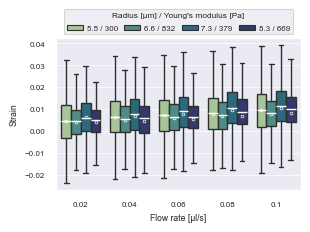

In [135]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

df_analysis['radius_plot'] = np.round(df_analysis['radius'], 1)
sns.boxplot(data=df_analysis, x='flow_rate', y='net_strain_inert',
            hue='radius_plot', palette='crest',
            dodge=True, showfliers=False,
            medianprops={'color': 'w'},
            showmeans=True, meanprops={'marker': '.',
                                       'markerfacecolor':'none',
                                       'markeredgecolor':'w',
                                       'markeredgewidth': 0.5,
                                       'markersize': 4},
            ax=ax, legend='full')

ax.set_xlabel("Flow rate [µl/s]")
ax.set_ylabel("Strain")

# Create legend manually for post-processing
handles, _ = ax.get_legend_handles_labels()
labels = ["5.5 / 300",
          "6.6 / 832",
          "7.3 / 379",
          "8.3 / 669"]
ax.legend(handles, labels, ncol=4, loc='lower center', bbox_to_anchor=[0.5, 1],
                 title="Radius [µm] / Young's modulus [Pa]", title_fontsize=6,
                 columnspacing=0.8, handletextpad=0.5, labelspacing=0.8)
plt.show()

save_path = "..\\figure_plots\\SI\\boxes_strain_inlet.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

In [141]:
df_analysis.groupby(['radius_plot', 'flow_rate']).count()['net_strain_inert']

radius_plot  flow_rate
5.5          0.02          786
             0.04          781
             0.06          806
             0.08          785
             0.10          749
6.6          0.02         2966
             0.04         4947
             0.06         5853
             0.08         5883
             0.10         7863
7.3          0.02          585
             0.04          973
             0.06         1951
             0.08         2429
             0.10         2429
8.3          0.02          445
             0.04          978
             0.06         1969
             0.08         2458
             0.10         2944
Name: net_strain_inert, dtype: int64

### Channel

In [97]:
data_exports = r"..\pre_pocessing\tracking_and_summarize\paam_beads_stress_measurements\data_exports"
path_20230607 = os.path.join(data_exports,
                             "20230607_beads_outside_hyper",
                             "20230810_beads_outside_hyper.tsv")
df_20230607 = pd.read_csv(os.path.abspath(path_20230607), sep='\t', index_col=0)
path_20230609 = os.path.join(data_exports,
                             "20230609_beads_outside_hyper",
                             "20230810_beads_outside_hyper.tsv")
df_20230609 = pd.read_csv(os.path.abspath(path_20230609), sep='\t', index_col=0)
df_all = pd.concat([df_20230607, df_20230609], ignore_index=True)
df_all = get_df_strain_features(df_all)
df_40x = df_all.loc[df_all['magnification'] == '40x']
df_ch = df_40x.loc[df_40x['region'] == 'channel']

C:\Users\freiche\AppData\Local\Temp\ipykernel_37280\2394973655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ch['radius_plot'] = np.round(df_ch['radius'], 1)


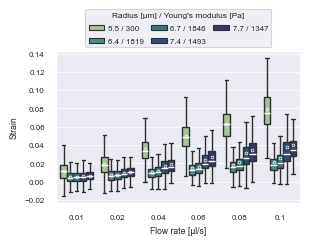

In [136]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

df_ch['radius_plot'] = np.round(df_ch['radius'], 1)
sns.boxplot(data=df_ch, x='flow_rate', y='net_strain_inert',
            hue='radius_plot', palette='crest',
            dodge=True, showfliers=False,
            medianprops={'color': 'w'},
            showmeans=True, meanprops={'marker': '.',
                                       'markerfacecolor':'none',
                                       'markeredgecolor':'w',
                                       'markeredgewidth': 0.5,
                                       'markersize': 4},
            ax=ax, legend='full')

ax.set_xlabel("Flow rate [µl/s]")
ax.set_ylabel("Strain")

# Create legend manually for post-processing
handles, _ = ax.get_legend_handles_labels()
labels = ["5.5 / 300",
          "6.4 / 1819",
          "6.7 / 1846",
          "7.4 / 1493",
          "7.7 / 1347"
          ]
ax.legend(handles, labels, ncol=3, loc='lower center', bbox_to_anchor=[0.5, 1],
          title="Radius [µm] / Young's modulus [Pa]", title_fontsize=6,
          columnspacing=0.8, handletextpad=0.5, labelspacing=0.8)
plt.show()

save_path = "..\\figure_plots\\SI\\boxes_strain_channel.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

In [142]:
df_ch.groupby(['radius_plot', 'flow_rate']).count()['net_strain_inert']

radius_plot  flow_rate
5.5          0.01         764
             0.02         792
             0.04         761
             0.06         770
             0.08         757
             0.10         714
6.4          0.01         984
             0.02         989
             0.04         993
             0.06         989
             0.08         991
             0.10         995
6.7          0.01         991
             0.02         983
             0.04         986
             0.06         988
             0.08         987
             0.10         984
7.4          0.01         981
             0.02         984
             0.04         986
             0.06         981
             0.08         968
             0.10         966
7.7          0.01         102
             0.02         214
             0.04         461
             0.06         483
             0.08         487
             0.10         494
Name: net_strain_inert, dtype: int64

### Hyperbolic region

In [148]:
df_hyper_strain_box \
    = df_median_objnr.drop(df_median_objnr[(df_median_objnr['sample'] == 'S03 Set3')
                                           & (df_median_objnr['flow_rate'] == 0.01)].index)
df_hyper_strain_box \
    = df_hyper_strain_box.drop(df_hyper_strain_box[(df_hyper_strain_box['sample'] == 'S03 Set4')
                                                   & (df_hyper_strain_box['flow_rate'] == 0.01)].index)

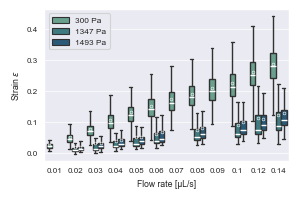

In [152]:
fsize = fsize_cm(8, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.boxplot(data=df_hyper_strain_box, 
            x='flow_rate', y='net_strain_inert_corr',
            hue='sample', palette='crest',
            hue_order=['S4', 'S03 Set3', 'S03 Set4'],
            dodge=True, showfliers=False,
            medianprops={'color': 'w'},
            showmeans=True, meanprops={'marker': '.',
                                       'markerfacecolor':'none',
                                       'markeredgecolor':'w',
                                       'markeredgewidth': 0.4,
                                       'markersize': 4},
            ax=ax, legend='full')

# ax.set_xlabel("Extension rate [s$^{-1}$]")
ax.set_xlabel("Flow rate [µL/s]")
ax.set_ylabel(r"Strain $\varepsilon$")
ax.tick_params(axis='both', which='major', pad=0)

handles, _ = ax.get_legend_handles_labels()
labels = ['300 Pa', '1347 Pa', '1493 Pa']
l = ax.legend(handles, labels,
              loc='upper left', #bbox_to_anchor=[1, 0],
              ncol=1, columnspacing=0.1, handletextpad=0.8,
              # title="Young's modulus", title_fontsize=7, 
              fontsize=6)
plt.show()

save_path = "..\\figure_plots\\SI\\boxes_strain_hyper.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

In [151]:
df_hyper_strain_box.groupby(['sample', 'flow_rate']).count()['net_strain_inert']

sample    flow_rate
S03 Set3  0.02          292
          0.03          387
          0.04          596
          0.05          795
          0.06          949
          0.08         1053
          0.10         1331
          0.12         1540
          0.14         1618
S03 Set4  0.02          190
          0.03          285
          0.04          360
          0.05          451
          0.06          493
          0.08          667
          0.10          792
          0.12          691
          0.14          453
S4        0.01          377
          0.02          552
          0.03          754
          0.04         1084
          0.05         1404
          0.06         1805
          0.07         1624
          0.08         1810
          0.09         1882
          0.10         1982
          0.12         1680
          0.14         1540
Name: net_strain_inert, dtype: int64